### MRI reconstruction demo
Single-coil under-sampled data reconstructed two ways:
* edge-preserving regularization (akin to corner-rounding anisotropic TV) using gradient-based methods
* synthesis sparsity via 1-norm of wavelet detail coefficients using fast proximal methods

Although this is a 2D demo, the k-space sampling pattern used here would be appropriate only for a 3D scan with phase encoding in the two dimensions shown here.  So this demo is akin to a single slice of a 3D scan with 2D undersampling.

2019-03-06 Jeff Fessler, University of Michigan

In [1]:
# load all packages needed for this demo 
using MIRT # https://github.com/JeffFessler/MIRT.jl
using LinearAlgebra
using Plots; default(markerstrokecolor=nothing)
using LinearMaps
using FFTW
using Random: seed!
using FFTViews
#include(ENV["HOME"] * "/l/g/teach/w19-598-opt/hw/auto/test/lipcheck.jl")

### Create (synthetic) data

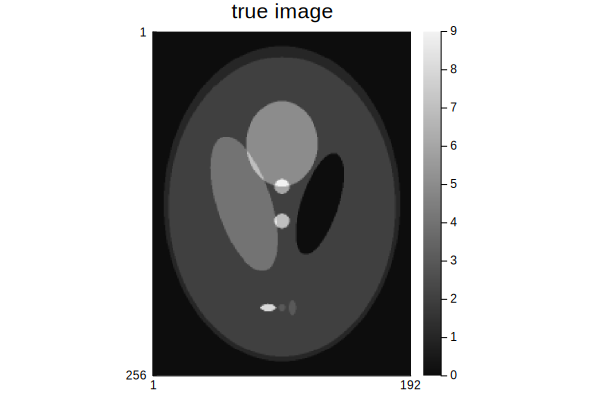

In [2]:
# shepp-logan phantom
nx,ny = 192,256
Xtrue = ellipse_im(ny, oversample=2)[Int((ny-nx)/2+1):Int(ny-(ny-nx)/2),:]
#Xtrue = ellipse_im(192, ny=256, oversample=2) # too small
nx,ny = size(Xtrue)
jim(Xtrue, "true image")

In [3]:
#savefig("xtrue.pdf")

In [4]:
# generate noisy, under-sampled k-space data
M,N = nx,ny
seed!(0); sampfrac = 0.3; samp = rand(M,N) .< sampfrac; sig = 1
mod2 = (N) -> mod.((0:N-1) .+ Int(N/2), N) .- Int(N/2)
samp .|= (abs.(mod2(M)) .< Int(M/8)) * (abs.(mod2(N)) .< Int(N/8))' # fully sampled center
@show sum(samp) / (M*N) # under-sampling factor

ytrue = fft(Xtrue)[samp]
y = ytrue + sig * randn(size(ytrue)) + 1im * sig * randn(size(ytrue)) # complex noise!
ysnr = 20 * log10(norm(ytrue) / norm(y-ytrue))
@show ysnr;

sum(samp) / (M * N) = 0.34259033203125
ysnr = 55.060019384539835


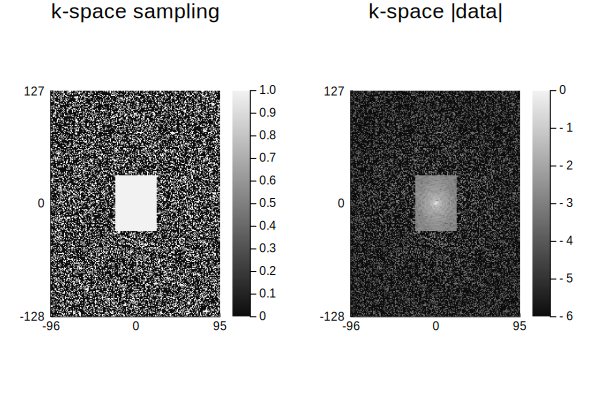

In [5]:
# display k-space sampling and zero-filled data
logger = (x;min=-6) -> log10.(max.(abs.(x) / maximum(abs.(x)), (10.)^min))
p1 = jim(samp, fft0=true, title="k-space sampling")
#savefig(p1, "samp.pdf")
jim(:abswarn, false) # suppress warnings about showing magnitude
p2 = jim(logger(embed(ytrue,samp)), fft0=true, title="k-space |data|")
plot(p1,p2)

### Prepare to reconstruct
Creating a system matrix (encoding matrix) and an initial image  
The system matrix is a `LinearMap` object, akin to a `fatrix` in Matlab MIRT.

In [6]:
# system model
F = LinearMap{Complex{Float32}}(
    x -> fft(reshape(x,M,N))[samp],
    y -> (M*N)*ifft(embed(y,samp))[:],
    sum(samp), M*N);

nrmse(X0) = 0.07550226812114964


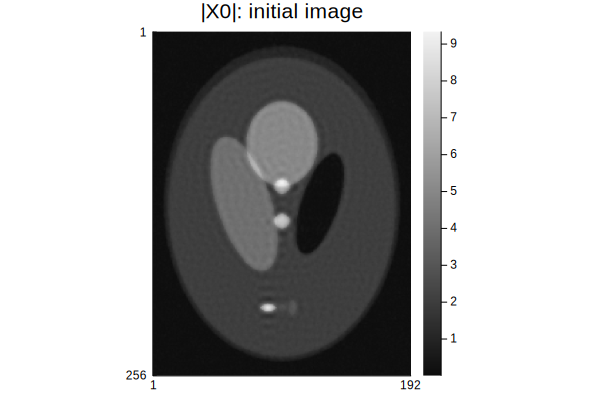

In [7]:
# initial image based on zero-filled reconstruction
nrmse = (x) -> norm(x[:] - Xtrue[:]) / norm(Xtrue[:])
X0 = reshape(1/(M*N) * (F' * y), M, N)
@show nrmse(X0)
jim(X0, "|X0|: initial image")

### Case 1: Edge-preserving regularization

The cost function here is
$
1/2 \|A x - y\|^2 + \beta \; \psi(T x)
$
where $\psi$ is the Fair potential function
and $T$ is first-order finite differences in 2D,
again implemented as a `LinearMap` object.

In [8]:
# Cost function for edge-preserving regularization
A = F
delta = 0.1
reg = 0.01 * M * N
T = diff_map(M,N) # finite differences sparsifying transform for anisotropic TV
pot = (z,del) -> del^2 * (abs(z)/del - log(1 + abs(z)/del)) # Fair potential function
cost = (x) -> 1/2 * norm(A * x - y)^2 + reg * sum(pot.(T*x, delta))
dpot = (z,del) -> z / (1 + abs(z)/del) # potential derivative

#18 (generic function with 1 method)

In [9]:
# Nonlinear CG recon using edge-preserving regularization
fun = (x,iter) -> (cost(x), nrmse(x), time())
niter = 50
xcg, out_cg = ncg([A, T], [u -> u - y, v -> reg * dpot.(v,delta)], [t -> 1, t -> reg],
    X0[:], niter=niter, fun=fun)
Xcg = reshape(xcg, M, N)
@show nrmse(Xcg)

nrmse(Xcg) = 0.015470464967956182


0.015470464967956182

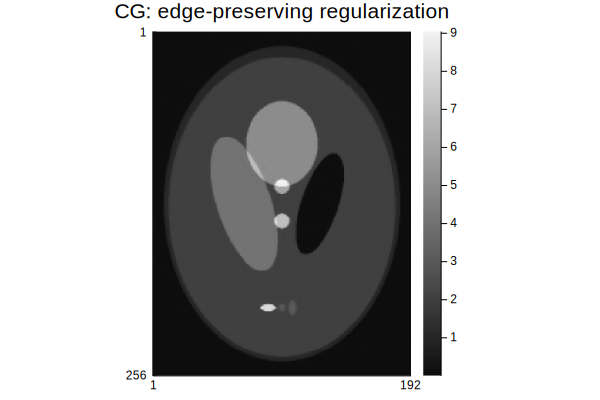

In [10]:
jim(Xcg, "CG: edge-preserving regularization")

In [11]:
#savefig("xcg.pdf")

In [12]:
# OGM line-search recon using edge-preserving regularization
xogm, out_ogm = ogm_ls([A, T], [u -> u - y, v -> reg * dpot.(v,delta)], [t -> 1, t -> reg],
    X0[:], niter=niter, ninner=20, fun=fun)
Xogm = reshape(xogm, M, N)
@show nrmse(Xogm)

nrmse(Xogm) = 0.01588192894211126


0.01588192894211126

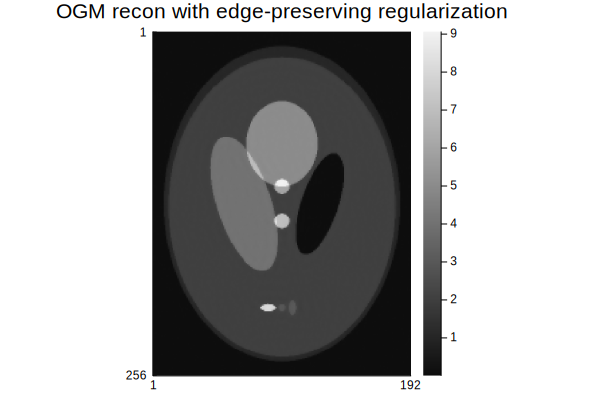

In [13]:
jim(Xogm, "OGM recon with edge-preserving regularization")

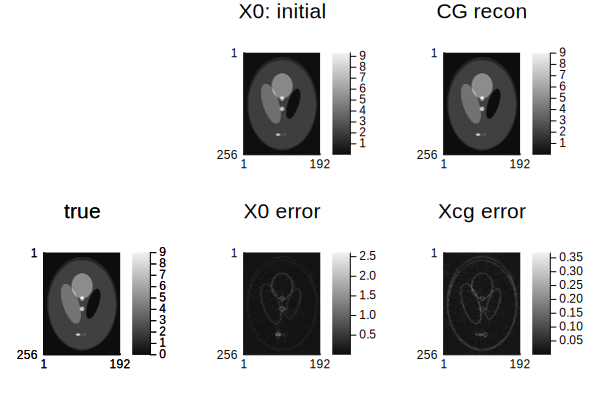

In [14]:
p1 = jim(Xtrue, "true")
p2 = jim(X0, "X0: initial")
p3 = jim(Xcg, "CG recon")
p5 = jim(X0 - Xtrue, "X0 error")
p6 = jim(Xcg - Xtrue, "Xcg error")
plot(p1, p2, p3, p1, p5, p6)
#plot(p1, p2, p3, layout=(1,3))
#plot(p5, p6)

In [15]:
# POGM - suboptimal in smooth case
if false
fun_pogm = (iter,xk,yk,rs) -> (cost(xk), nrmse(xk), rs)
f_grad = (x) -> A'*(A*x - y) + reg * (T' * dpot.(T * x, delta))
L_f = N*M + 8*reg
x_pogm, out_pogm = pogm_restart(X0[:], cost, f_grad, L_f;
    mom=:pogm, niter=niter, fun=fun_pogm)
Xpogm = reshape(x_pogm, M, N)
@show nrmse(Xpogm)
end

In [16]:
#lipcheck(f_grad, L_f, X0[:], show=true)

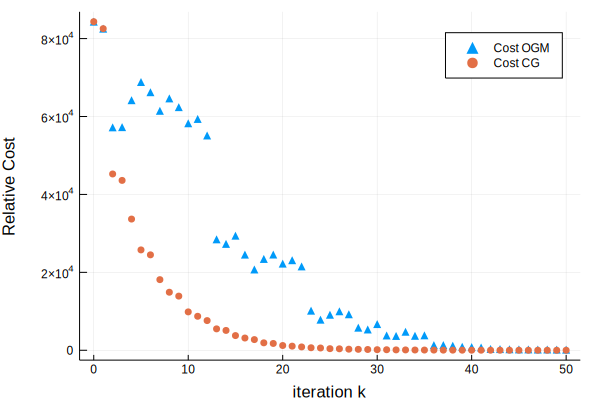

In [17]:
# plot cost vs iteration
cost_cg = [out_cg[k][1] for k=1:niter+1]
cost_ogm = [out_ogm[k][1] for k=1:niter+1]
cost_min = min(minimum(cost_cg), minimum(cost_ogm))
plot(xlabel="iteration k", ylabel="Relative Cost")
scatter!(0:niter, cost_ogm .- cost_min, markershape=:utriangle, label="Cost OGM")
scatter!(0:niter, cost_cg  .- cost_min, label="Cost CG")

In [18]:
#savefig("cost_ogm_cg.pdf")

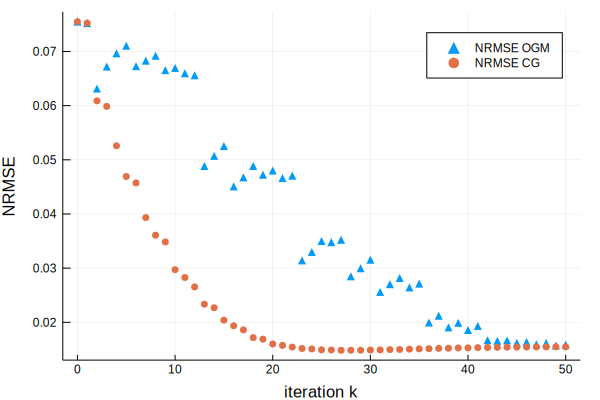

In [19]:
# plot nrmse vs iteration
nrmse_cg = [out_cg[k][2] for k=1:niter+1]
nrmse_ogm = [out_ogm[k][2] for k=1:niter+1]
#nrmse_pogm = [out_pogm[k][2] for k=1:niter+1]
plot(xlabel="iteration k", ylabel="NRMSE")
scatter!(0:niter, nrmse_ogm, markershape=:utriangle, label="NRMSE OGM")
scatter!(0:niter, nrmse_cg, label="NRMSE CG")
#scatter!(0:niter, nrmse_pogm, label="NRMSE POGM")

In [20]:
#savefig("nrmse_ogm_cg.pdf")

In [21]:
#nrmse(x_pogm), nrmse(X0)

In [22]:
#?pogm_restart

### Case 2: Wavelet sparsity in synthesis form

The cost function here is
$
1/2 \|A x - y\|^2 + \beta \; \|W x\|_1
$
where
and $W$ is an orthogonal discrete (Haar) wavelet transform,
again implemented as a `LinearMap` object.
Because $W$ is unitary,
we make the change of variables
$z = W x$
and solve for $z$
and then let $x = W' z$
at the end.

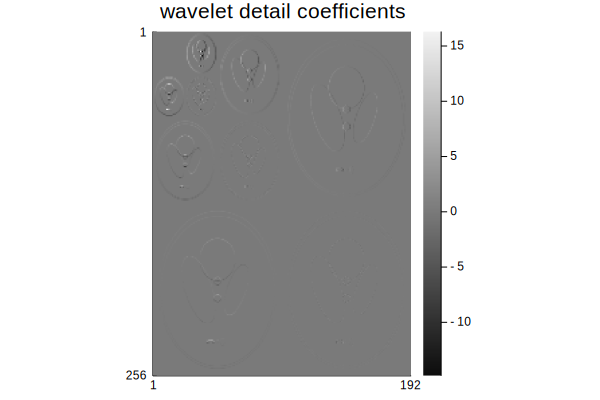

In [23]:
W, scales, mfun = Aodwt((M,N)) # Orthogonal discrete wavelet transform (LinearMap)
jim(mfun(W,Xtrue) .* (scales .> 0), "wavelet detail coefficients")

In [24]:
# Cost function for edge-preserving regularization
Az = F * W'
Fnullz = (z) -> 0 # not needed
f_gradz = (z) -> Az' * (Az * z - y)
f_Lz = M*N # single coil cartesian DFT
regz = 0.03 * M * N # oracle from Xtrue wavelet coefficients!
pot = (z,del) -> del^2 * (abs(z)/del - log(1 + abs(z)/del)) # Fair potential function
costz = (z) -> 1/2 * norm(Az * z - y)^2 + reg * norm(z,1) # 1-norm regularizer
soft = (z,c) -> sign(z) * max(abs(z) - c, 0) # soft thresholding
g_prox = (z,c) -> soft.(z, regz * c) # proximal operator
z0 = W * X0[:];

#### Run ISTA=PGM and FISTA=FPGM and POGM, the latter two with adaptive restart
See [http://doi.org/10.1007/s10957-018-1287-4]

nrmse(Xista) = 0.017643775152922307
nrmse(Xfista) = 0.017094485379346203
nrmse(Xpogm) = 0.017094556407130364


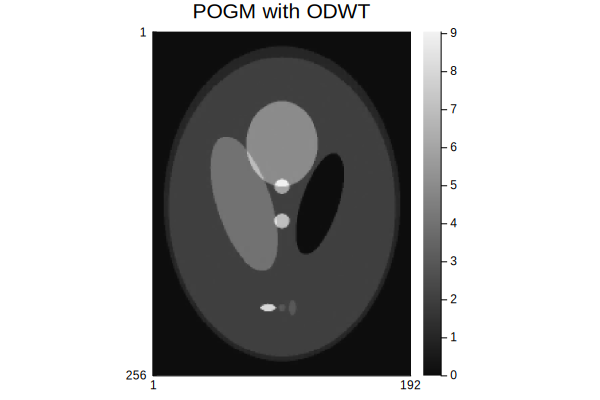

In [25]:
# Run proximal methods
function fun_ista(iter, xk_z, yk, is_restart)
    if mod(iter, 50) == 0
#        @show iter
    end
    xh = W' * xk_z
return (costz(xk_z), nrmse(xh), is_restart) # , psnr(xh)) # time()
end

function fun_fista(iter, xk, yk_z, is_restart)
    xh = W' * yk_z
    return (costz(yk_z), nrmse(xh), is_restart) # , psnr(xh)) # time()
end

z_ista, out_ista = pogm_restart(z0, Fnullz, f_gradz, f_Lz; mom=:pgm, niter=niter,
    restart=:none, restart_cutoff=0., g_prox=g_prox, fun=fun_ista)
Xista = reshape(W'*z_ista, M, N)
@show nrmse(Xista)

z_fista, out_fista = pogm_restart(z0, Fnullz, f_gradz, f_Lz; mom=:fpgm, niter=niter,
    restart=:gr, restart_cutoff=0., g_prox=g_prox, fun=fun_fista)
Xfista = reshape(W'*z_fista, M, N)
@show nrmse(Xfista)

z_pogm, out_pogm = pogm_restart(z0, Fnullz, f_gradz, f_Lz; mom=:pogm, niter=niter,
    restart=:gr, restart_cutoff=0., g_prox=g_prox, fun=fun_fista)
Xpogm = reshape(W'*z_pogm, M, N)
@show nrmse(Xpogm)

jim(Xfista, "FISTA/FPGM")
jim(Xpogm, "POGM with ODWT")

In [26]:
#savefig("xpogm_odwt.pdf")

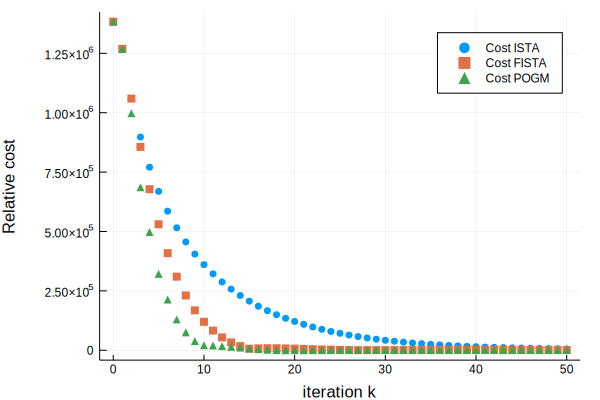

In [27]:
# plot cost vs iteration
cost_ista = [out_ista[k][1] for k=1:niter+1]
cost_fista = [out_fista[k][1] for k=1:niter+1]
cost_pogm = [out_pogm[k][1] for k=1:niter+1]
cost_min = min(minimum(cost_ista), minimum(cost_pogm))
plot(xlabel="iteration k", ylabel="Relative cost")
scatter!(0:niter, cost_ista  .- cost_min, label="Cost ISTA")
scatter!(0:niter, cost_fista .- cost_min, markershape=:square, label="Cost FISTA")
scatter!(0:niter, cost_pogm  .- cost_min, markershape=:utriangle, label="Cost POGM")

In [28]:
#savefig("cost_pogm_odwt.pdf")

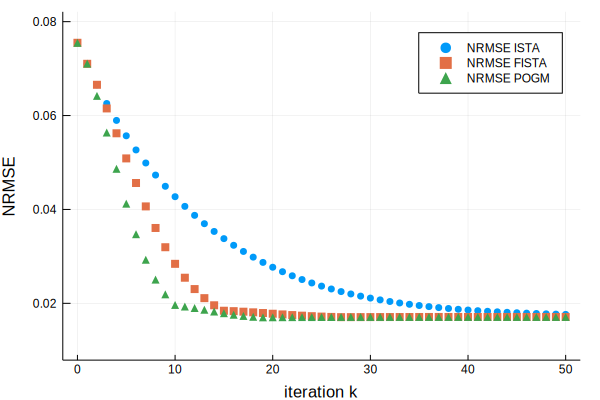

In [29]:
# plot nrmse vs iteration
nrmse_ista = [out_ista[k][2] for k=1:niter+1]
nrmse_fista = [out_fista[k][2] for k=1:niter+1]
nrmse_pogm = [out_pogm[k][2] for k=1:niter+1]
plot(xlabel="iteration k", ylabel="NRMSE", ylim=[0.01,0.08])
scatter!(0:niter, nrmse_ista, label="NRMSE ISTA")
scatter!(0:niter, nrmse_fista, markershape=:square, label="NRMSE FISTA")
scatter!(0:niter, nrmse_pogm, markershape=:utriangle, label="NRMSE POGM")

In [30]:
#savefig("nrmse_pogm_odwt.pdf")

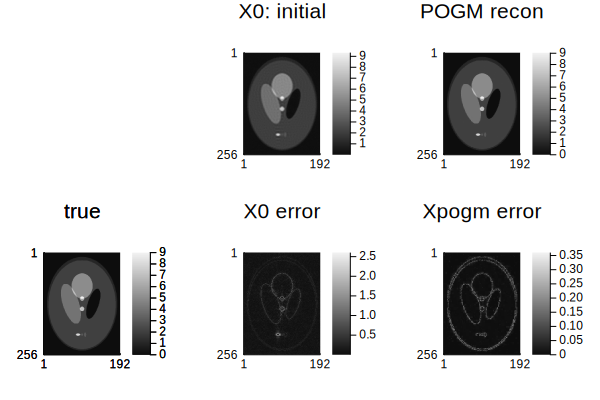

In [31]:
p1 = jim(Xtrue, "true")
p2 = jim(X0, "X0: initial")
p3 = jim(Xpogm, "POGM recon")
p5 = jim(X0 - Xtrue, "X0 error")
p6 = jim(Xpogm - Xtrue, "Xpogm error")
plot(p1, p2, p3, p1, p5, p6)
#plot(p1, p2, p3, layout=(1,3))
#plot(p5, p6)